# CA4 - Habitable planets

Nida Grønbekk

We want to predict wheter a planet is non-habitable (0), potentially habitable (1) or very habitable (2).

## Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from numpy import interp

## Importing the data

In [2]:
train_data=pd.read_csv('train.csv')
train_data

,radiation_level,pressure,alien_prob,flare_prob,growth_potential,h2o,target
0,57.500,0.410,9.300,14.9500,3.000,0,non_habitable
1,53.430,0.580,1.500,12.6850,2.900,0,non_habitable
2,65.375,0.460,3.922,13.4600,2.541,0,non_habitable
3,60.884,0.742,14.361,12.3385,NaN,0,non_habitable
4,72.625,0.968,3.323,9.3230,4.144,1,very_habitable
...,...,...,...,...,...,...,...
2484,84.750,0.447,10.100,13.9450,NaN,0,non_habitable
2485,50.610,0.766,5.600,7.9950,NaN,0,non_habitable
2486,47.000,0.757,-4.656,18.1330,3.836,0,very_habitable
2487,26.953,0.978,1.977,5.0060,4.793,1,potentially_habitable


Change target to be 0,1,2 instead of the strings given.

In [3]:
X=train_data[train_data.columns[:6]]
y=train_data[train_data.columns[6]]

In [4]:
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['non_habitable', 'potentially_habitable', 'very_habitable'],
      dtype=object)

In [5]:
le.transform(['non_habitable', 'potentially_habitable','very_habitable'])

array([0, 1, 2])

Check if there is any missing values:

In [6]:
train_data.isnull().sum()

radiation_level       0
pressure              0
alien_prob            0
flare_prob            0
growth_potential    543
h2o                   0
target                0
dtype: int64

There is 543 missing values in the growth_potential column. Need to handle this.

The test data:

In [7]:
test=pd.read_csv('test.csv')
test.isnull().sum()

radiation_level       0
pressure              0
alien_prob            0
flare_prob            0
growth_potential    374
h2o                   0
dtype: int64

Note that also the test data has missing values in the same feature. Need to handle this when predicting target values later on.

## Visualization

### Violin plot

<AxesSubplot:title={'center':'Identified traces of H2O on the surface'}>

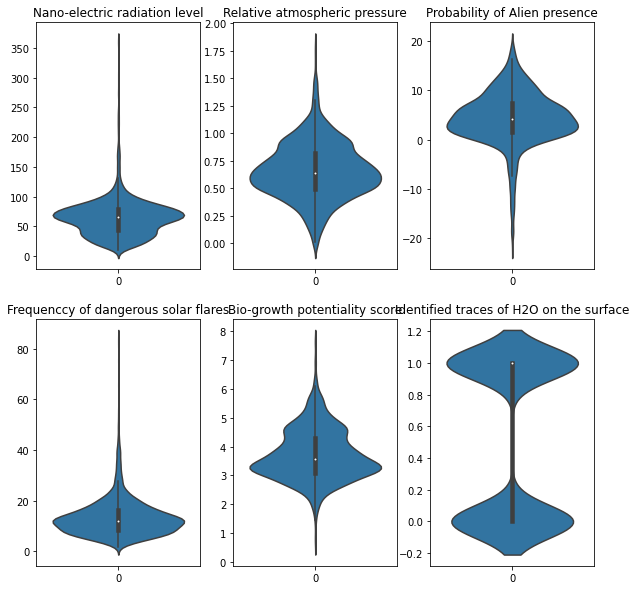

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(10,10))
#2 rows 3 columns
axs[0,0].set_title('Nano-electric radiation level')
sns.violinplot(data=train_data[train_data.columns[0]],ax=axs[0,0])

axs[0,1].set_title('Relative atmospheric pressure')
sns.violinplot(data=train_data[train_data.columns[1]],ax=axs[0,1])

axs[0,2].set_title('Probability of Alien presence')
sns.violinplot(data=train_data[train_data.columns[2]],ax=axs[0,2])

axs[1,0].set_title('Frequenccy of dangerous solar flares')
sns.violinplot(data=train_data[train_data.columns[3]],ax=axs[1,0])

axs[1,1].set_title('Bio-growth potentiality score')
sns.violinplot(data=train_data[train_data.columns[4]],ax=axs[1,1])

axs[1,2].set_title('Identified traces of H2O on the surface')
sns.violinplot(data=train_data[train_data.columns[5]],ax=axs[1,2])

All of the variables have outliers, but some stand out as having more extreme outliers. "Nano-electric radiation level" has most values between 0 and 100, but a few values of 350, 3.5 times as large! "The frequency of dangerous solar flares" have most values between 0 and 30, but a few values of 90. "The probability of alien prescence" has values mostly between -5 and 20, but some values are -25. The violin plot of "Identified traces of H2O" might look weird, but have in mind this is a boolean variable (0,1). Can not actually look for outliers in such a variable.

### Scatter Matrix

I want to include the target in the visualization, however the target is not included if we use the intial version of the data where y is string values, make a new dataframe where target is 0,1,2.

In [9]:
visual_data=pd.DataFrame(data=X)
visual_data['target']=y

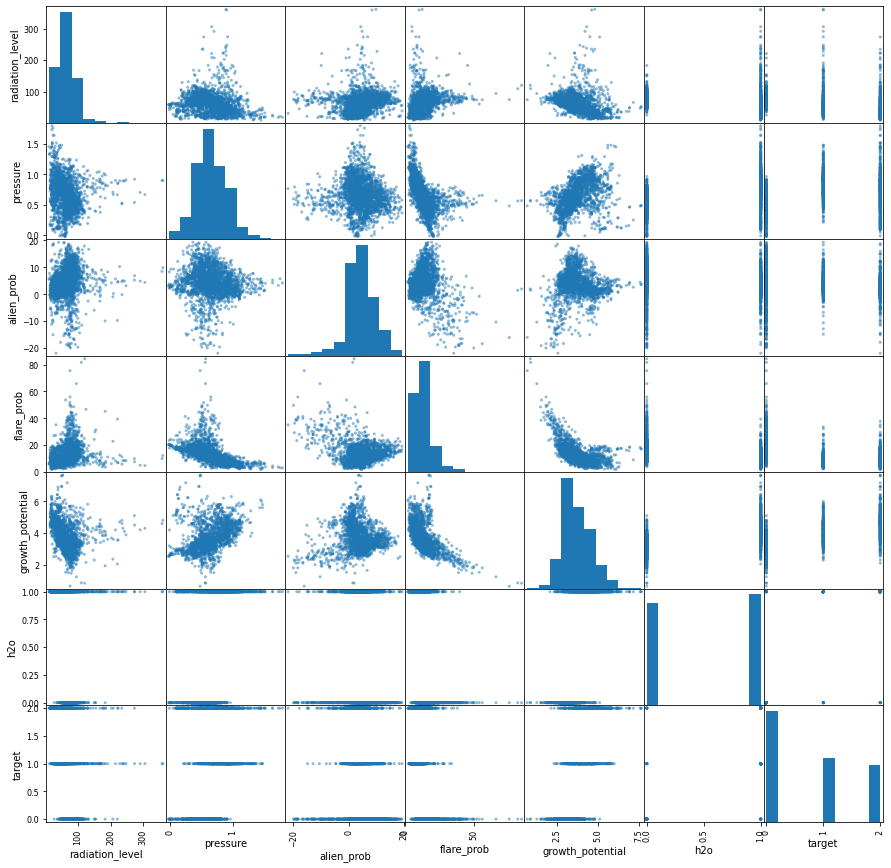

In [10]:
axes=pd.plotting.scatter_matrix(visual_data, figsize=(15,15))

Most of the plots seem like clouds of points, no clear trend. flare_prob vs. growth_potential seem like they follow a logarithmic trend. Maybe a slightly linear trend between pressure and flare_prob (if removing outliers). However in most cases there is no clear trend of the points.

We can see from the target vs. target plot that most observations are from the 0 class (non-habitable).

### Correlation matrix

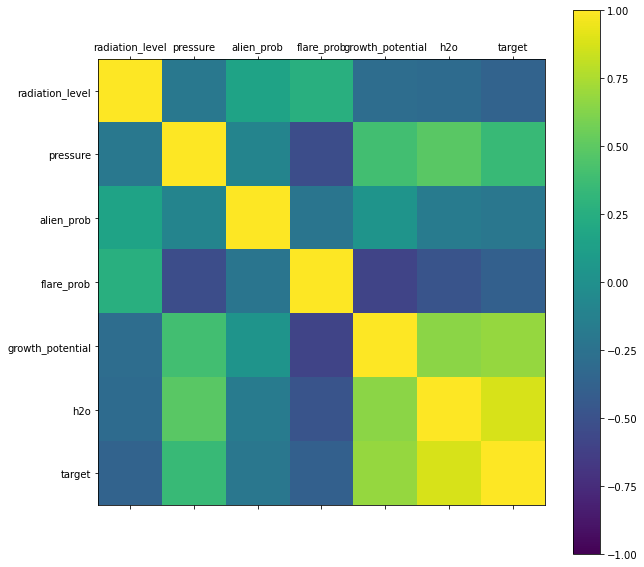

In [11]:
correlations = visual_data.corr()
# the code is retrieved from the lecture code
fig = plt.figure(figsize=(10,10))
# # add a subplot for the colorbar
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, 7, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(list(visual_data.columns))
ax.set_yticklabels(list(visual_data.columns))
plt.show()

We can see a high correlation between H2O and the target (close to 1). growth_potential and target, growth_potential and H2O also has high correlation (>0.75). Most of the other variables has a correlation of around +/- 0.5, not that high, but still a clear correlation. Since H2O and growth_potential has such a high correlation with the target value, they might be of high importance when predicting the habitability of a planet.


## About the missing data. 
We see that growth_potential had high correlation with the target and with H2O, it seems like this feature is important, so simply dropping the enitre column because of the missing values would not be wise. 

We need to consider and test different ways to handle the missing values, I will try the following:
- drop rows with missing values
- KNNImputer
- IterativeImputer

Simply dropping rows with missing values can work in our case, as we have many samples to begin with, dropping the rows would result in a dataset with 2498-543=1955 rows, which is still a lot. However, we should check if imputing missing values could improve performance.

## The task

We want to optimize two different pipelines, one including regularization. And the other including Kernels. For the pipeline with regularization this means that we will try the models that allow l1 and l2 regularization, which is:
 - Logistic Regression
 - Perceptron
 
For the pipeline with kernel we will try for the models that implement a kernel, which is
 - Support Vector Machine Classifier (both linear and rbf kernel)

We will also try KernelPCA in combination with a classifier.

## Solution to missing data

I performed nested CV to get an estimate of test accuracy for each of the models we have gone through in the course til now, using the tree different datasets mentioned. In each case (for each model), the data where missing values was imputed using IterativeImputer got the best estimate out of the three. We choose to continue with this version of the dataset. As the test set also had missing values, we use the same imputer to impute the missing values of this dataset in order to be able to make predictions later on.

In [12]:
df = pd.DataFrame(X)
df['target']=y
# impute missing values using IterativeImputer
it=IterativeImputer(random_state=1)
imputed_data=it.fit_transform(df)
column_names=list(df.columns)
imputed_data=pd.DataFrame(imputed_data,columns=column_names)

Imputing the test data:

In [13]:
test_data=it.fit_transform(test)
test_data=pd.DataFrame(test_data,columns=column_names[:-1])

Overwrite X to be the version where missing data is imputed.

In [14]:
X=imputed_data[imputed_data.columns[:6]]

## The regularization pipeline

I already think Perceptron will perform worse, however I performed nested CV just in case, and the result showed that logistic regression did indeed have a better test accuracy estimate. I proceed with the logistic regression model.

I wanted to see if including some dimension reduction before the model fitting would better the performance so I performed nested CV. First on a pipeline with just the model, and then on a pipeline with PCA and the model. The estimate did not improve in the case where PCA was included, so we do not include PCA. I will now try to find the best parameters for the logistic regression model. Since GridSearch uses Cross-Validation one could use the entire dataset to find these parameters. However we want to get the confusion matrix of the model, so we decide to split in training and test set, and then perform gridsearch on the new training set. 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [16]:
pipe_lr = make_pipeline(StandardScaler(),LogisticRegression(solver = 'saga', multi_class='auto', 
                                          random_state=1))
c_val=[10**x for x in range(-6,6)]
param_grid_lr = [{'logisticregression__C':c_val,'logisticregression__penalty':['l1','l2','elasticnet']}]
gs_lr = GridSearchCV(estimator=pipe_lr,
                    param_grid=param_grid_lr,
                    scoring='accuracy',
                    cv=10,
                    n_jobs=-1)
gs_lr = gs_lr.fit(X_train, y_train)
print(gs_lr.best_score_)
print(gs_lr.best_params_)

0.873694581280788
{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}


C:\Users\Nida\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.47933333 0.47933333        nan 0.47933333 0.47933333        nan
 0.47933333 0.47933333        nan 0.47933333 0.81687685        nan
 0.85189491 0.86565846        nan 0.86967159 0.87369458        nan
 0.87196388 0.87253859        nan 0.87368473 0.87368473        nan
 0.87368473 0.87368473        nan 0.87368473 0.87368473        nan
 0.87368473 0.87368473        nan 0.87368473 0.87368473        nan]
  warnings.warn(


Note: I chose saga solver as it supports both l1 and l2 penalty according to the documentation.

We got the best performance when using C=10^(-1) and l2 regularization. Let us fit the model with best parameters on the entire training set and predict the test set and upload to kaggle.

In [18]:
clf_lr = gs_lr.best_estimator_
clf_lr.fit(X, y)
predicted_lr=clf_lr.predict(test_data)

# # dataframe of predictions
id_col=[i for i in range(0,test_data.shape[0])]
dict_val={'id': id_col,'Predicted': predicted_lr}
results=pd.DataFrame(dict_val)
results=results.set_index('id')
results.to_csv('results_lr.csv')

When uploading to Kaggle it got a score of 0.84186. I wanted to see if removing outliers could help the model. I first performed nested CV to get an indication if it was better or not, which it was. Then found best parameters. However when uploading to kaggle the score was 0.82379, which is worse. The model probably fitted too well to the training data. Stick with the version using all of the data.

### Performance Evaluation Metrics

We now present the confusion matrix produced by predicting the test values, and the test accuracy.

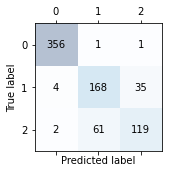

In [19]:
# Predict class for X_test
y_pred_lr=gs_lr.predict(X_test)
# Get the values for the confusion matrix
confmat_lr = confusion_matrix(y_true=y_test, y_pred=y_pred_lr)
# start plot
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_lr, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_lr.shape[0]):
    for j in range(confmat_lr.shape[1]):
        ax.text(x=j, y=i, s=confmat_lr[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [20]:
test_acc_lr = sum(y_test==y_pred_lr)/len(y_test)
print('Test accuracy:',test_acc_lr)

Test accuracy: 0.8607764390896921


## The kernel pipeline

I wanted to test out models that uses a kernel, and combinations of kernel PCA with other models in a pipeline.

**For the Support Vector Machine:** To decide on which model to choose, I performed nested CV on two pipelines, one with SVC linear kernel and one with SVC rbf kernel. The SVC model with rbf kernel got a much better estimate, I hence proceed with this one. 

I then wanted to see if maybe dimension reduction via PCA before fitting the SVC model with rbf kernel would improve the performance, and executed nested CV for a pipeline with PCA and the model. The one with PCA got a better test estimate. I also do this for Kernel PCA to see if it improves the model. The estimate got better.


**For the kernel PCA:** When I first started this CA4 I tried to find the best model among the ones we have been thaught so far. Therefore I performed nested CV on each model (with the three dataset options) and found the best models to be Random Forest, KNN and SVC. I try to see if KernelPCA in combination with each of these three gives a good estimate according to nested CV. 

The best estimate was achieved for SVC with rbf kernel and KernelPCA. We therefore try to find the best parameters for this:

In [ ]:
# first scale data, then perform kernelpca, and then SVC of the transformed data.
pipe_kernel = make_pipeline(StandardScaler(), KernelPCA(random_state=1), 
                      SVC(kernel='rbf',random_state=1))
# We want to find best values for c and gamma in svc in these ranges:
gamma_val=[10**x for x in range(-3,3)]
c=[10**x for x in range(-3,4)]
# the parameters we want to test for
params_kernel=[{'kernelpca__n_components':[1,2,3,4,5,6],
                'svc__gamma':gamma_val,'svc__C':c, 
                'kernelpca__kernel':['linear','rbf','poly','cosine','sigmoid',
                           'precomputed']}]
# Perform 10-fold CV of the pipeline with the parameters given above
gs_kernel = GridSearchCV(estimator=pipe_kernel, 
                  param_grid=params_kernel, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
# Perform this 10 fold CV on the training set
gs_kernel = gs_kernel.fit(X_train, y_train)
# Get the best score and parameters achieved for the gridsearch
print(gs_kernel.best_score_)
print(gs_kernel.best_params_)


The model is best when using 5 components in the kernelPCA and a sigmoid kernel, and using C=10 and gamma= 10 in the SVC model.

We use the best parameters to fit a model on the entire training set and predicting the test set:

In [21]:
# Use the best parameters for the model
clf_kernel = gs_kernel.best_estimator_
# Fit on the entire training set
clf_kernel.fit(X, y)
# predict y for the test data
predicted_kernel=clf_kernel.predict(test_data)

# # dataframe of predictions
id_col=[i for i in range(0,test_data.shape[0])]
dict_val={'id': id_col,'Predicted': predicted_kernel}
results=pd.DataFrame(dict_val)
results=results.set_index('id')
results.to_csv('C:\\Users\\Nida\\NMBU\\DAT200\\CA4\\results_svc_kpca.csv')

When uploading to Kaggle I got a score of 0.87198. This is much better than the regularization model.

### Performance Evaluation Metrics

We now present the confusion matrix and test accuracy for our model.

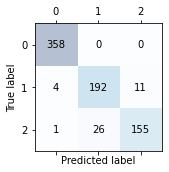

In [22]:
y_pred_k=gs_kernel.predict(X_test)
confmat_k = confusion_matrix(y_true=y_test, y_pred=y_pred_k)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_k, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_k.shape[0]):
    for j in range(confmat_k.shape[1]):
        ax.text(x=j, y=i, s=confmat_k[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

In [23]:
test_accuracy = sum(y_test==y_pred_k)/len(y_test)
print('Test accuracy:',test_accuracy)

Test accuracy: 0.9437751004016064


## Best result

To summarize. We got the best score on kaggle when choosing the kernel pipeline. Which consists of scaling, dimension reduction with kernelPCA and the Support Vector Machine Classifier with rbf kernel. The best score: **0.87198**.

## ROC curve

We now consider the two class problem in distinction between non-habitable (y=0) and very habitable (y=2) planets. I choose classifier Logistic Regression with l2 penalty to distinguish between the two. Include PCA in the pipeline. We will now produce a ROC-curve based on 5-fold cross-validation.

Get the part of the dataset with only the two classes:

In [24]:
df=X
df['target']=y

two_class_df=df.loc[df['target'] != 1].reset_index()

X_roc=two_class_df[two_class_df.columns[:6]]
y_roc=two_class_df[two_class_df.columns[6]]

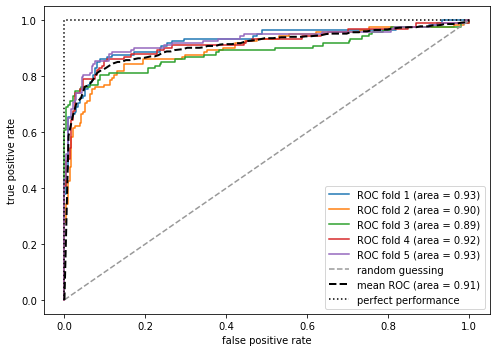

In [25]:
# create the pipeline
pipe_roc = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(penalty='l2',
                                                                    random_state=1,solver='lbfgs',
                                                                    C=100))

# specify the cross-validation
cv = list(StratifiedKFold(n_splits=5).split(X_roc, y_roc))
# this gives list of pairs of lists, each pair of two lists represents test and training indexes. 
# Each pair tells us which indexes (folds) to train on, and which indexes (fold) to test on.

# start the figure
fig = plt.figure(figsize=(7, 5))

# variable to store mean true predictive rate
mean_tpr = 0.0
# draw random number between 0 and 1 for mean false positive rate
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# Now we iterate through the folds (given as lists of lists of indexes)
for i, (train, test) in enumerate(cv):
    # predict the probabilities of each sample in test set to be in either of the classes
    # fit pipeline on training set, then predict test set
    probabilities = pipe_roc.fit(X_roc.loc[train],
                         y_roc.loc[train]).predict_proba(X_roc.loc[test]) 
    
    # Calculate False Positive and True Positive Rates (thresholds for the decision function)
    fpr, tpr, thresholds = roc_curve(y_roc.loc[test], probabilities[:, 1], pos_label=1) 
    # Add to mean True Predictive Rate in a smoothed variant (interpolated)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    # get the area under the curve
    roc_auc = auc(fpr, tpr)
    # Plot the roc curve for the current fold
    # true positive rate along y-axis, false positive rate along x-axis
    plt.plot(fpr, tpr, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    
# plot the line that shows random guessing, if we fall below this the model is extremely bad 
plt.plot([0, 1],[0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

# Average True Positive Rate
mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0

# Average AUC, the mean ROC curve
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

# the perfect model would fall on this line.
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

We can see from the ROC curve that all folds, and the mean, perform quite well as they all are close to the line representing the perfect model. There is some variance between the folds, but not much.